In [1]:
import pandas as pd
import numpy as np
import functools
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
import model_set
import random
import tensorflow as tf
from train_predict import train_se,predict_se,train_predict_rank

c:\Users\YM\anaconda3\envs\hao\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the diffusion model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def index_iterator(device, data_len, batchsize = 32):
    perm_idx = np.random.permutation(data_len)
    num_steps = (data_len // batchsize) if (data_len % batchsize) == 0 else (data_len // batchsize) + 1
    for ii in range(num_steps):
        if ii < (num_steps - 1):
            batch_idx = perm_idx[(ii*batchsize):(ii*batchsize+batchsize)]
        else:
            batch_idx = perm_idx[(ii*batchsize):]
        
        yield batch_idx

class Diffusion_SDE(nn.Module):
    def __init__(self, input_dim, cond_dim, time_emb_dim = 32, eps=1e-5, sigma = 100, scale = 9,block_layer =1, device=None):
        super(Diffusion_SDE, self).__init__()
        self.device = device
        self.marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
        self.diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)
        self.eps = eps
        self.score_model = UNet_MLP(input_dim, cond_dim, self.marginal_prob_std_fn, time_emb_dim = time_emb_dim, scale = scale, block_layer = block_layer).to(device)
        self.input_dim = input_dim
    
    def forward(self, x0, cond):
        # 前向加噪声的过程
        random_t = torch.rand(x0.shape[0], device=self.device) * (1. - self.eps) + self.eps 
        z = torch.randn_like(x0)
        std = self.marginal_prob_std_fn(random_t)
        perturbed_x = x0 + z * std[:, None]
        # U-Net模型
        score = self.score_model(perturbed_x, cond, random_t) * std[:, None]
        loss = torch.mean(torch.sum((score  + z)**2, dim=1))
        
        return loss
    
    def em_sampler(self, cond, num_steps=1000,eps=1e-3):
        sample_size = cond.shape[0]
        t = torch.ones(sample_size, device=self.device)
        init_x = torch.randn((sample_size, self.input_dim), device=self.device) \
        * self.marginal_prob_std_fn(t)[:, None]
        time_steps = torch.linspace(1., eps, num_steps, device=device)
        step_size = time_steps[0] - time_steps[1]
        x = init_x

        with torch.no_grad():
            for time_step in time_steps:      
                batch_time_step = torch.ones(sample_size, device=device) * time_step
                g = self.diffusion_coeff_fn(batch_time_step)
                mean_x = x + (g**2)[:, None] * (self.score_model(x, cond, batch_time_step)) * step_size

                x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        return mean_x
            
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class MyBlock(nn.Module):
    def __init__(self, shape, out_c, block_layer):
        super(MyBlock, self).__init__()
        self.w1 = nn.Linear(shape, out_c)
        self.block_layer = block_layer
        for nl in range(2,self.block_layer+1):
            setattr(self,"w_"+str(nl),nn.Linear(out_c,out_c))
        self.activation = lambda x: x * torch.sigmoid(x)


    def forward(self, x):
        out = self.w1(x)
        out = self.activation(out)
        for nl in range(2,self.block_layer+1):
            out = self.activation(getattr(self,"w_"+str(nl))(out))
        return out


def marginal_prob_std(t, sigma):
    #t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return sigma**t
  

class UNet_MLP(nn.Module):
    def __init__(self, input_dim, cond_dim, marginal_prob_std, time_emb_dim=32, scale = 4, block_layer = 1):
        super(UNet_MLP, self).__init__()

        # Sinusoidal embedding
        self.act = lambda x: x * torch.sigmoid(x)
        # Sinusoidal embedding
        self.time_embed = nn.Sequential(GaussianFourierProjection(embed_dim=time_emb_dim),
         nn.Linear(time_emb_dim, time_emb_dim))

        
        self.marginal_prob_std = marginal_prob_std
        
        self.input_dim = input_dim
        
        # First half
        first_num = 2 ** scale
        self.x_embed = MyBlock(input_dim,first_num,block_layer)
        
        self.te1 = self._make_emb(time_emb_dim, first_num)
        self.ce1 = self._make_emb(cond_dim, first_num)
        self.b1 = MyBlock(first_num, first_num,block_layer)

        

        second_num = first_num // 2
        self.down1 = MyBlock(first_num,second_num,block_layer)
        
        self.te2 = self._make_emb(time_emb_dim, second_num)
        self.ce2 = self._make_emb(cond_dim, second_num)
        self.b2 = MyBlock(second_num,second_num,block_layer)
    
        
        third_num = second_num // 2
        self.down2 = MyBlock(second_num,third_num,block_layer)


        # Bottleneck
        self.te_mid = self._make_emb(time_emb_dim, third_num)
        self.ce_mid = self._make_emb(cond_dim, third_num)
        self.b_mid = MyBlock(third_num, third_num,block_layer)
    

        # Second half
        self.up1 = MyBlock(third_num, second_num,block_layer)

        self.te3 = self._make_emb(time_emb_dim, first_num)
        self.ce3 = self._make_emb(cond_dim, first_num)
        self.b3 = MyBlock(first_num, second_num,block_layer)

        self.up2 = MyBlock(second_num, first_num,block_layer)
        self.te4 = self._make_emb(time_emb_dim, first_num * 2)
        self.ce4 = self._make_emb(cond_dim, first_num * 2)
        self.b4 = MyBlock(first_num * 2, first_num,block_layer)
        

        self.final = nn.Linear(first_num, input_dim)

    def forward(self, x0, xc, ti):
        
        t = self.act(self.time_embed(ti))
        x = self.x_embed(x0)
        
        out1 = self.b1(x + self.te1(t) + self.ce1(xc))   # (N, first_num) 
        out2 = self.b2(self.down1(out1) + self.te2(t) + self.ce2(xc))    # (N, second_num)
        out_mid = self.b_mid(self.down2(out2)+ self.te_mid(t) + self.ce_mid(xc))   # (N, third_num)

        out3 = torch.cat((out2, self.up1(out_mid)), dim=1)  # (N, first_num)
        out4 = self.b3(out3+ self.te3(t)+ self.ce3(xc))    # (N, second)

        out5 = torch.cat((out1, self.up2(out4)), dim=1)  # (N, first_num * 2)
        out6 = self.b4(out5+ self.te4(t)+ self.ce4(xc))    # (N, first_num)

        out = self.final(out6) # (N, out)

        return out / self.marginal_prob_std(ti)[:, None]

    def _make_emb(self, dim_in, dim_out):
        return nn.Linear(dim_in, dim_out)

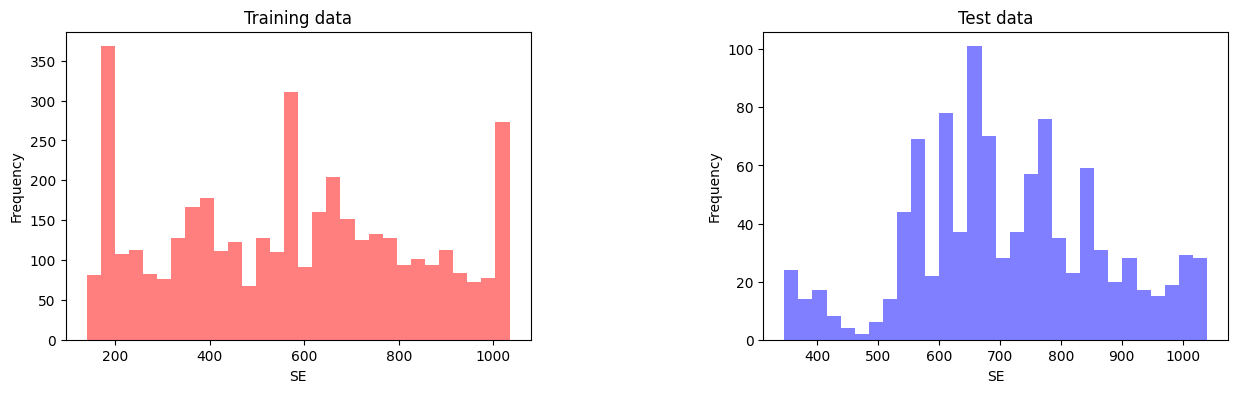

In [15]:
CSI_RSRP_COLUMNS = ['PCell1 -Beam CSI-RSRP','PCell2 -Beam CSI-RSRP','PCell3 -Beam CSI-RSRP',
                    'PCell4 -Beam CSI-RSRP','PCell5 -Beam CSI-RSRP','PCell6 -Beam CSI-RSRP','PCell7 -Beam CSI-RSRP','PCell8 -Beam CSI-RSRP']
CSI_RSRQ_COLUMNS = ['PCell1 -Beam CSI-RSRQ','PCell2 -Beam CSI-RSRQ','PCell3 -Beam CSI-RSRQ',
                    'PCell4 -Beam CSI-RSRQ','PCell5 -Beam CSI-RSRQ','PCell6 -Beam CSI-RSRQ','PCell7 -Beam CSI-RSRQ','PCell8 -Beam CSI-RSRQ']
CSI_SINR_COLUMNS = ['PCell1 -Beam CSI-SINR','PCell2 -Beam CSI-SINR','PCell3 -Beam CSI-SINR',
                    'PCell4 -Beam CSI-SINR','PCell5 -Beam CSI-SINR','PCell6 -Beam CSI-SINR','PCell7 -Beam CSI-SINR','PCell8 -Beam CSI-SINR']
CSI_INDEX_COLUMNS = ['PCell1 -Beam CSI-Index','PCell2 -Beam CSI-Index','PCell3 -Beam CSI-Index',
                    'PCell4 -Beam CSI-Index','PCell5 -Beam CSI-Index','PCell6 -Beam CSI-Index','PCell7 -Beam CSI-Index','PCell8 -Beam CSI-Index']
SS_SINR_COLUMNS = ['SSB Index0 SINR','SSB Index1 SINR','SSB Index2 SINR','SSB Index3 SINR','SSB Index4 SINR','SSB Index5 SINR','SSB Index6 SINR']
SS_RSRP_COLUMNS = ['SSB Index0 RSRP','SSB Index1 RSRP','SSB Index2 RSRP','SSB Index3 RSRP','SSB Index4 RSRP','SSB Index5 RSRP','SSB Index6 RSRP']
CSI_SERVING_COL = ['PCell1 -Beam Serving Beam','PCell2 -Beam Serving Beam','PCell3 -Beam Serving Beam','PCell4 -Beam Serving Beam','PCell5 -Beam Serving Beam',
                   'PCell6 -Beam Serving Beam','PCell7 -Beam Serving Beam','PCell8 -Beam Serving Beam']
CSI_RSRP_IDX_COLUNMS = ['CSI-RSRP-Index0', 'CSI-RSRP-Index1', 'CSI-RSRP-Index2', 'CSI-RSRP-Index3', 'CSI-RSRP-Index4', 'CSI-RSRP-Index5','CSI-RSRP-Index6', 'CSI-RSRP-Index7',
                        'CSI-RSRP-Index8', 'CSI-RSRP-Index9', 'CSI-RSRP-Index10', 'CSI-RSRP-Index11', 'CSI-RSRP-Index12','CSI-RSRP-Index13', 'CSI-RSRP-Index14', 'CSI-RSRP-Index15',
                        'CSI-RSRP-Index16', 'CSI-RSRP-Index17', 'CSI-RSRP-Index18', 'CSI-RSRP-Index19','CSI-RSRP-Index20', 'CSI-RSRP-Index21', 'CSI-RSRP-Index22', 'CSI-RSRP-Index23',
                        'CSI-RSRP-Index24', 'CSI-RSRP-Index25', 'CSI-RSRP-Index26', 'CSI-RSRP-Index27', 'CSI-RSRP-Index28', 'CSI-RSRP-Index29', 'CSI-RSRP-Index30', 'CSI-RSRP-Index31']
CSI_SINR_IDX_COLUNMS = ['CSI-SINR-Index0', 'CSI-SINR-Index1', 'CSI-SINR-Index2', 'CSI-SINR-Index3', 'CSI-SINR-Index4', 'CSI-SINR-Index5','CSI-SINR-Index6', 'CSI-SINR-Index7',
                        'CSI-SINR-Index8', 'CSI-SINR-Index9', 'CSI-SINR-Index10', 'CSI-SINR-Index11', 'CSI-SINR-Index12','CSI-SINR-Index13', 'CSI-SINR-Index14', 'CSI-SINR-Index15',
                        'CSI-SINR-Index16', 'CSI-SINR-Index17', 'CSI-SINR-Index18', 'CSI-SINR-Index19','CSI-SINR-Index20', 'CSI-SINR-Index21', 'CSI-SINR-Index22', 'CSI-SINR-Index23',
                        'CSI-SINR-Index24', 'CSI-SINR-Index25', 'CSI-SINR-Index26', 'CSI-SINR-Index27', 'CSI-SINR-Index28', 'CSI-SINR-Index29', 'CSI-SINR-Index30', 'CSI-SINR-Index31']
PERFORMANCE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s','NR PRB Num DL/slot','NR RI','NR Avg Rank DL/s',
                       'NR DL Total NACK/s','NR DL Total ACK/s','NR PDSCH Initial BLER','NR PDSCH BLER','NR DL Avg MCS'] 
LOC_COLUMNS = ['Longitude','Latitude']
ALL_COLUMNS = CSI_RSRP_COLUMNS+CSI_RSRQ_COLUMNS+CSI_SINR_COLUMNS+CSI_INDEX_COLUMNS+SS_SINR_COLUMNS+SS_RSRP_COLUMNS+PERFORMANCE_COLUMNS
# 归一化参数
RSRP_MAX = -40
RSRP_MIN = -125
RSRQ_MAX = -4
RSRQ_MIN = -30
SE_MAX = 4000
RI_MAX = 4
MCS_MAX = 27
SINR_MAX = 50
SINR_MIN = -20
RI_COLUMN = ['NR Avg Rank DL/s']
MCS_COLUMN = ['NR DL Avg MCS']
BLER_COLUMN = ['NR PDSCH BLER']
SEVING_IDX = ['Serving idx']

SE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s']
train_features = LOC_COLUMNS+CSI_RSRP_IDX_COLUNMS+SS_RSRP_COLUMNS

# with open('dt_cuhk/0415/data_set/data_834_linear_by_idx.pkl','rb') as f:
#     data_set_834_415 = pickle.load(f)
# with open('dt_cuhk/0412/data_set/data_900_linear_by_idx.pkl','rb') as f:
#     data_set_900_412 = pickle.load(f)
# with open('dt_cuhk/0418/data_set/data_834_linear_by_idx.pkl','rb') as f:
#     data_set_834_418 = pickle.load(f)
# with open('dt_cuhk/0420/data_set/data_834_linear_by_idx.pkl','rb') as f:
#     data_set_834_420 = pickle.load(f)
# with open('dt_cuhk/0426/data_set/data_834_linear_by_idx.pkl','rb') as f:
#     data_set_834_426 = pickle.load(f)
    
with open('dataset_514/0412/data_900_linear_by_idx_loc.pkl','rb') as f:
    data_set_900_412 = pickle.load(f)

LANGITUDE = [114,115]
LATITUDE = [22,23]
data_set_900_412[LOC_COLUMNS[0]] = (data_set_900_412[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
data_set_900_412[LOC_COLUMNS[1]] = (data_set_900_412[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])

# train,test = train_test_split(data_set_900_412,test_size=0.2,shuffle=False)
with open('dataset_503/data_900_train_test.pkl','rb') as f:
    train,test = pickle.load(f)
    
train_x = train[train_features]
train_y = train['SE']

test_x = test[train_features]
test_y = test['SE']



# 创建三个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一个子图
axs[0].hist(train['NR MAC Throughput DL'], bins=30, alpha=0.5, color='r')
axs[0].set_xlabel('SE')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training data')


# 绘制第二个子图
axs[1].hist(test['NR MAC Throughput DL'], bins=30, alpha=0.5, color='b')
axs[1].set_xlabel('SE')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test data')

# 调整子图之间的距离
plt.subplots_adjust(wspace=0.5)

# 显示图像
plt.show()


train_x = train_x[train_features].to_numpy()
test_x = test_x[train_features].to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()


cond_dim = len(train_features)
X_tensor = torch.FloatTensor(train_y).reshape(-1,1)
r_tensor = torch.FloatTensor(train_x[:,:cond_dim])

# train the diffusion score model

In [16]:
# diffusion_process = Diffusion_SDE(input_dim = 2, cond_dim=1, scale = 9,block_layer=2, sigma = 100, device=device)
diffusion_process = Diffusion_SDE(input_dim = 1, cond_dim=cond_dim, scale = 9,block_layer=2, sigma = 100, device=device)

In [19]:
# training 
batchsize = 128
epoch = 2000
lr = 1e-4
optimizer = Adam(diffusion_process.parameters(), lr)

# initialize best loss and corresponding model state dict
best_loss = float('inf')
best_model_state_dict = None
patience = 20 # 超过patience个epoch没有loss下降就停止训练
no_improvement_count = 0 # 记录连续没有改善的epoch数
steps = 0
avg_loss = 0
progress = tqdm(range(epoch))
for ep in progress:
    for batch_index in index_iterator(device, len(X_tensor), batchsize = 256):
        optimizer.zero_grad()
        steps +=1 
        x0 = X_tensor[batch_index].cuda()
        xc = r_tensor[batch_index].cuda()
        loss = diffusion_process(x0, xc)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
       
    progress.set_postfix({"avg_loss":avg_loss/(steps+1)})
    if ep % 100 == 0:     
        torch.save(diffusion_process.state_dict(), "model.pkl")
        print("save model")
        
    # check if current loss is better than best loss
    if avg_loss/(steps+1) < best_loss:
        best_loss = avg_loss/(steps+1)
        no_improvement_count = 0
        best_model_state_dict = diffusion_process.state_dict()
    else:
        no_improvement_count += 1
    if no_improvement_count >= patience:
        print("Early stopping at epoch", ep)
        break
        
# save the best model to file
if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "best_model_900.pkl")
    print("save best model with loss: ", best_loss)

  0%|          | 1/2000 [00:00<12:44,  2.61it/s, avg_loss=0.00517]

save model


  5%|▌         | 101/2000 [00:22<07:03,  4.48it/s, avg_loss=0.00356]

save model


  6%|▌         | 124/2000 [00:27<06:55,  4.52it/s, avg_loss=0.00359]

Early stopping at epoch 124
save best model with loss:  0.0035395848409744764


# draw sample from diffusion for val data

In [20]:
test_tensor = torch.FloatTensor(test_x[:,:cond_dim]).to(device)
test_y_tensor = torch.FloatTensor(test_y)

In [21]:
diffusion_process.load_state_dict(torch.load("best_model_900.pkl"))
# diffusion_process.load_state_dict(torch.load("best_model_copy.pkl"))
sample_size = 100 # the number of sample to draw from diffusion for each input
sampled_y_1 = torch.cat([diffusion_process.em_sampler(test_tensor).cpu() for _ in tqdm(range(sample_size))],axis=1)

100%|██████████| 100/100 [04:27<00:00,  2.68s/it]


# deterministic prediction given by mlp and SVR

In [22]:
# 从文件中加载模型
new_model = tf.keras.models.load_model('mlp_model_900_1')
print('Model loaded from mlp_model_900.')
mlp_est_y = new_model.predict(test_x).flatten()
# 从文件中加载模型
with open('svr_model_900.pkl', 'rb') as f:
    svr_model = pickle.load(f)
print('Model loaded from svr_model_900.pkl')
svr_y = svr_model.predict(test_x).flatten()

Model loaded from mlp_model_900.
Model loaded from svr_model_900.pkl


# compare mlp and diffusion

In [23]:
used_sample_size = sample_size
# sample_y_mean = sampled_y[:,:used_sample_size].mean(axis=1)
sample_y_mean = sampled_y_1[:,:used_sample_size].mean(axis=1)

# plt.figure(figsize=(15,10))
# plt.plot(mlp_est_y[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="by mlp")
# plt.plot(sampled_y[:60,0]*SE_MAX,".",alpha=0.7,markersize=20,label="just one sample")
# plt.plot(sample_y_mean[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="use mean of {} samples".format(used_sample_size))
# plt.plot(test_y[:60]*SE_MAX,".",alpha=0.7,markersize=20,label="ground truth")
# plt.title('Spectral Efficiency((bit/Number))')
# plt.xlabel('Sample ID')
# plt.legend(prop={"size":10})
# plt.show()

In [24]:
print('mse:')
print("diffusion average min error over 10 samples:", np.mean(((sampled_y_1[:,:10].numpy()-test_y.reshape(-1,1))**2).min(axis=1)))
# print("diffusion average min error over 100 samples:", np.mean(((sampled_y_1[:,:100].numpy()-test_y.reshape(-1,1))**2).min(axis=1)))
print("diffusion mean:", np.mean((sample_y_mean.numpy()-test_y)**2))
print("mlp:", np.mean((mlp_est_y-test_y)**2))
print("svr :", np.mean((svr_y-test_y)**2))
print('max error:')
# print("diffusion average min error over 10 samples:", np.max(((sampled_y_1[:,:10].numpy()-test_y.reshape(-1,1))**2).min(axis=1)))
print("diffusion mean:", np.max((sample_y_mean.numpy()-test_y)**2),)
print("mlp:",np.max((mlp_est_y-test_y)**2))
print("svr:", np.max((svr_y-test_y)**2))
print('mape:')
print("diffusion average min error over 10 samples:", np.mean((np.abs((sampled_y_1[:,:10].numpy()-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
# print("diffusion average min error over 100 samples:", np.mean((np.abs((sampled_y_1[:,:100].numpy()-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
print("diffusion mean:",np.mean(np.abs((sample_y_mean.numpy()-test_y)/test_y)))
print("mlp:",np.mean(np.abs((mlp_est_y-test_y)/test_y)))
print("svr:",np.mean(np.abs((svr_y-test_y)/test_y)))
print('sdape:')
print("diffusion average min error over 10 samples:", np.std((np.abs((sampled_y_1[:,:10].numpy()-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
# print("diffusion average min error over 100 samples:", np.std((np.abs((sampled_y_1[:,:100].numpy()-test_y.reshape(-1,1))/test_y.reshape(-1,1))).min(axis=1)))
print("diffusion mean:",np.std(np.abs((sample_y_mean.numpy()-test_y)/test_y)))
print("mlp:",np.std(np.abs((mlp_est_y-test_y)/test_y)))
print("svr:",np.std(np.abs((svr_y-test_y)/test_y)))

mse:
diffusion average min error over 10 samples: 0.004537804341765233
diffusion mean: 0.00831657298456002
mlp: 0.012088568184406548
svr : 0.005961455820032619
max error:
diffusion mean: 0.09267029604521364
mlp: 0.13578941469349887
svr: 0.08327324327348398
mape:
diffusion average min error over 10 samples: 0.08242219719309929
diffusion mean: 0.1315813519570765
mlp: 0.15061342648507262
svr: 0.11671411363506524
sdape:
diffusion average min error over 10 samples: 0.10040102683652374
diffusion mean: 0.11633551577046464
mlp: 0.12164293207698984
svr: 0.09044560463904273


# plot 99% confidence interval

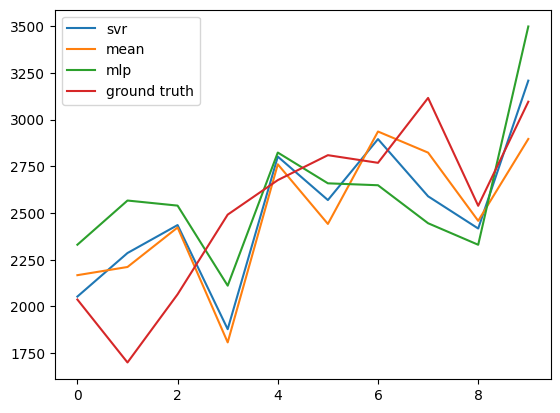

In [13]:
num_samples = 10
x_range = np.arange(num_samples)
sample_indices = random.sample(range(len(test_y)), num_samples)
plt.plot(svr_y[sample_indices]*SE_MAX,label="svr")
plt.plot(sample_y_mean[sample_indices]*SE_MAX,label="mean")
plt.plot(mlp_est_y[sample_indices]*SE_MAX,label="mlp")
plt.plot(test_y[sample_indices]*SE_MAX,label="ground truth")
plt.legend()
plt.show()

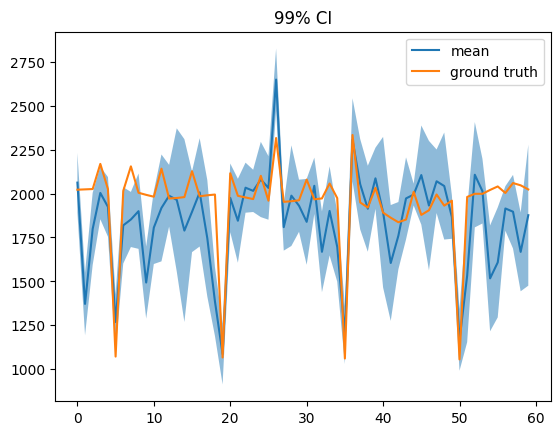

coverage of 90% CI 37.45059288537549
coverage of 95% CI 42.88537549407115
coverage of 99% CI 54.347826086956516
coverage of min-max interval 55.533596837944664


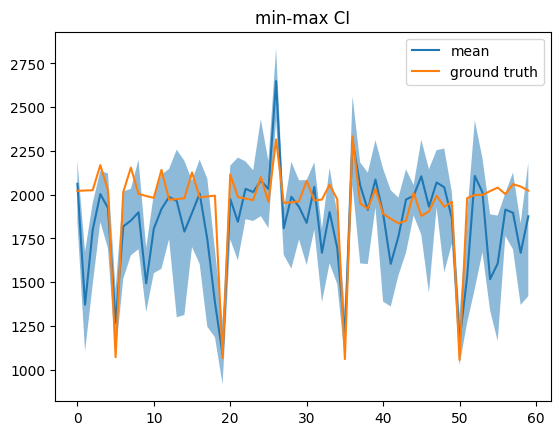

In [25]:
sample_y_std = sampled_y_1[:,:used_sample_size].std(axis=1)

CI90 = 1.645
CI95 = 1.96
CI99 = 2.576

plt.plot(sample_y_mean[:60]*SE_MAX,label="mean")
plt.fill_between(np.arange(60),(sample_y_mean[:60]-CI99*sample_y_std[:60])*SE_MAX,(sample_y_mean[:60]+CI99*sample_y_std[:60])*SE_MAX,alpha=0.5)
plt.plot(test_y[:60]*SE_MAX,label="ground truth")
plt.legend()
plt.title("99% CI")
plt.show()

print("coverage of 90% CI", np.mean((test_y>=(sample_y_mean-CI90*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI90*sample_y_std).numpy())) * 100)
print("coverage of 95% CI", np.mean((test_y>=(sample_y_mean-CI95*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI95*sample_y_std).numpy())) * 100)
print("coverage of 99% CI", np.mean((test_y>=(sample_y_mean-CI99*sample_y_std).numpy()) & (test_y<=(sample_y_mean+CI99*sample_y_std).numpy())) * 100)
print("coverage of min-max interval", np.mean((test_y>=sampled_y_1[:,:used_sample_size].min(axis=1).values.numpy()) & (test_y<=sampled_y_1[:,:used_sample_size].max(axis=1).values.numpy())) * 100)

plt.plot(sample_y_mean[:60]*SE_MAX,label="mean")
plt.fill_between(np.arange(60),(sampled_y_1[:,:used_sample_size].min(axis=1).values.numpy()[:60])*SE_MAX,(sampled_y_1[:,:used_sample_size].max(axis=1).values.numpy()[:60])*SE_MAX,alpha=0.5)
plt.plot(test_y[:60]*SE_MAX,label="ground truth")
plt.legend()
plt.title("min-max CI")
plt.show()